# Tesla Stock Price vs. Elon Musk's Tweet LikeCount

This notebook visualizes the relationship between Tesla's daily closing stock price and the total likeCount of Elon Musk's tweets per day.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

current_dir = os.getcwd()
clean_data_dir = os.path.join(current_dir,'..' ,'data', 'clean')


# Load Tesla stock data
stock = pd.read_csv(f'{clean_data_dir}/clean_tesla_stock.csv', parse_dates=['Date'])
# Load Musk tweets data
tweets = pd.read_csv(f'{clean_data_dir}/clean_musk_tweets.csv', parse_dates=['timestamp'])

stock.head(), tweets.head()

(        Date      Open      High       Low     Close       Volume
 0 2010-06-30  1.719333  2.028000  1.553333  1.588667  257806500.0
 1 2010-07-01  1.666667  1.728000  1.351333  1.464000  123282000.0
 2 2010-07-02  1.533333  1.540000  1.247333  1.280000   77097000.0
 3 2010-07-06  1.333333  1.333333  1.055333  1.074000  103003500.0
 4 2010-07-07  1.093333  1.108667  0.998667  1.053333  103825500.0,
                                                 text  retweetCount  \
 0  Please ignore prior tweets, as that was someon...         697.0   
 1  Went to Iceland on Sat to ride bumper cars on ...          27.0   
 2  I made the volume on the Model S http://t.co/w...          19.0   
 3  Great Voltaire quote, arguably better than Twa...          36.0   
 4                  That was a total non sequitur btw          12.0   
 
    replyCount  likeCount  quoteCount  viewCount                 timestamp  \
 0      1422.0     6392.0       400.0        NaN 2010-06-04 18:31:57+00:00   
 1        40.

## Prepare and Aggregate Data
- Aggregate tweets by day, summing likeCount.
- Merge with Tesla's daily closing price.
    

In [9]:
# Aggregate tweets by day
tweets['date'] = tweets['timestamp'].dt.date
daily_likes = tweets.groupby('date')['likeCount'].sum().reset_index()
daily_likes['date'] = pd.to_datetime(daily_likes['date'])

# Prepare stock data
stock['Date'] = pd.to_datetime(stock['Date'])

# Merge on date
merged = pd.merge(stock, daily_likes, left_on='Date', right_on='date', how='left')
merged['likeCount'] = merged['likeCount'].fillna(0)

merged[['Date', 'Close', 'likeCount']].head()

,Date,Close,likeCount
0,2010-06-30,1.588667,0.0
1,2010-07-01,1.464000,0.0
2,2010-07-02,1.280000,0.0
3,2010-07-06,1.074000,0.0
4,2010-07-07,1.053333,0.0


## Visualize: TSLA Close Price and Musk Tweet LikeCount (Daily)


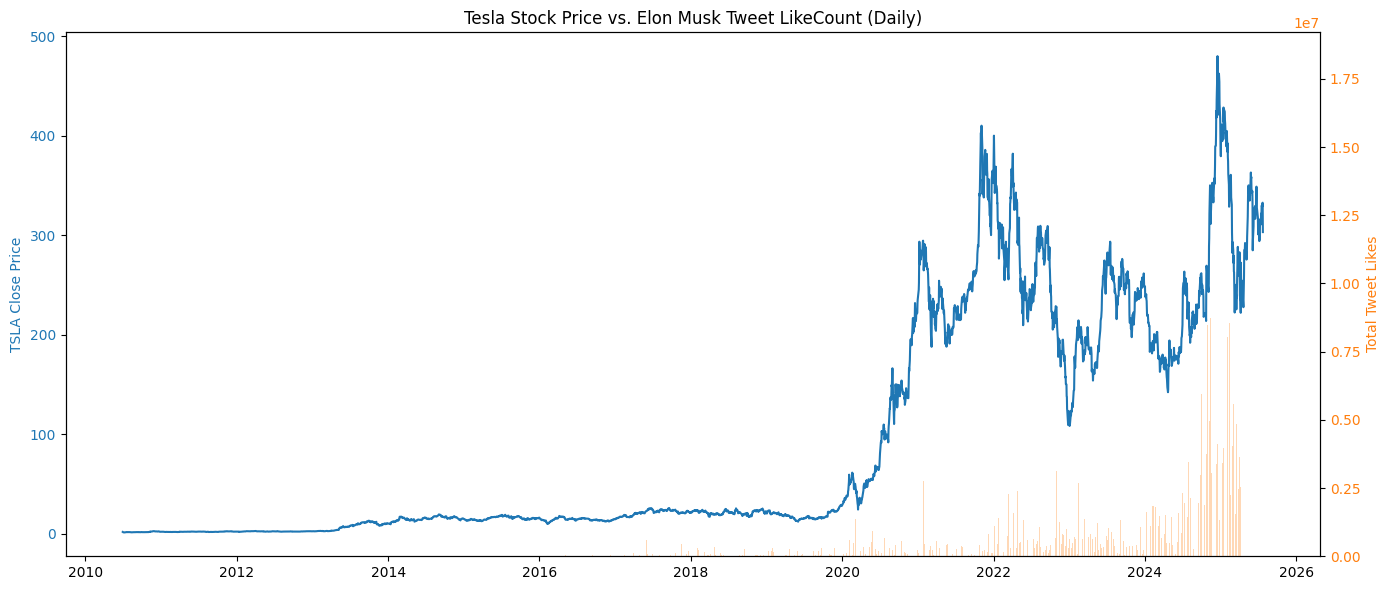

In [10]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(merged['Date'], merged['Close'], color='tab:blue', label='TSLA Close Price')
ax1.set_ylabel('TSLA Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.bar(merged['Date'], merged['likeCount'], color='tab:orange', alpha=0.3, label='Total Tweet Likes')
ax2.set_ylabel('Total Tweet Likes', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title("Tesla Stock Price vs. Elon Musk Tweet LikeCount (Daily)")
fig.tight_layout()
plt.show()

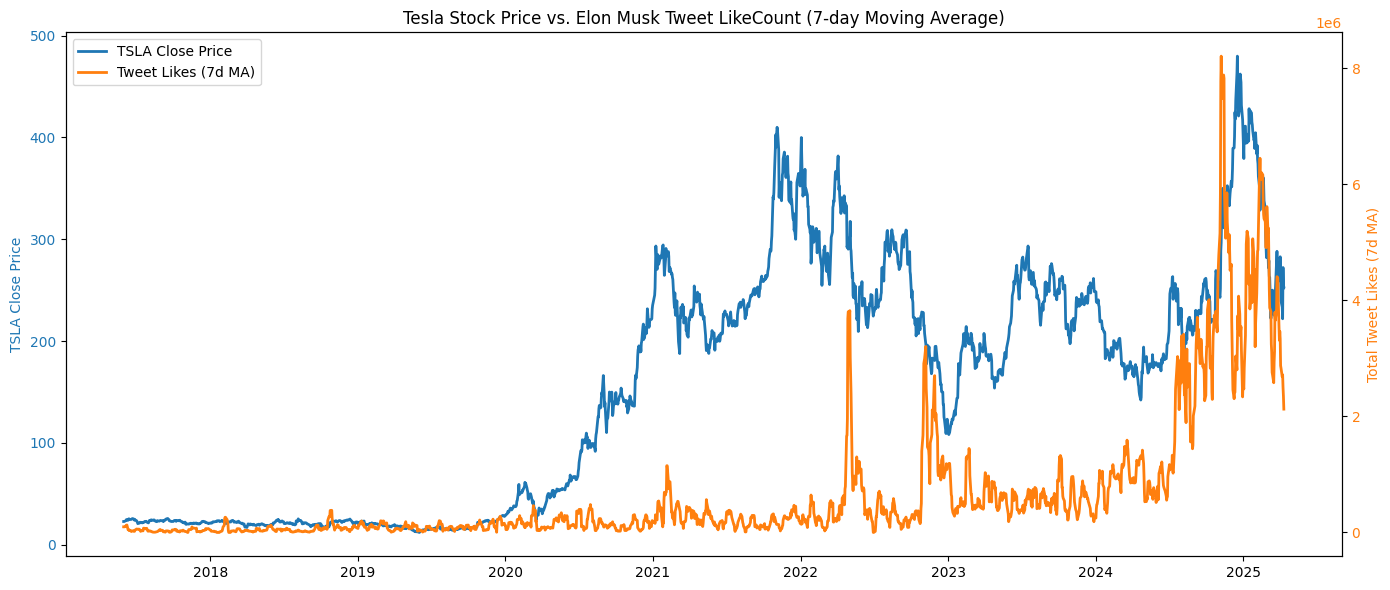

In [21]:
daily_likes['date'] = pd.to_datetime(daily_likes['date'])
# Prepare stock: ensure date alignment
stock['Date'] = pd.to_datetime(stock['Date'])
merged = pd.merge(stock, daily_likes, left_on='Date', right_on='date', how='left')
# Fill missing likeCounts with 0 (no tweets that day)
merged['likeCount'] = merged['likeCount'].fillna(0)
merged['likeCount_MA7'] = merged['likeCount'].rolling(window=7, min_periods=1).mean()

# Filter to period where tweet activity is nonzero
start_date = merged[merged['likeCount_MA7'] > 40000]['Date'].min()
last_tweet_date = tweets['timestamp'].dt.date.max()
filtered = merged[
    (merged['Date'] >= start_date) & (merged['Date'] <= pd.to_datetime(last_tweet_date))
]

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(filtered['Date'], filtered['Close'], color='tab:blue', label='TSLA Close Price', linewidth=2)
ax1.set_ylabel('TSLA Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(filtered['Date'], filtered['likeCount_MA7'], color='tab:orange', label='Tweet Likes (7d MA)', linewidth=2)
ax2.set_ylabel('Total Tweet Likes (7d MA)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')


# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("Tesla Stock Price vs. Elon Musk Tweet LikeCount (7-day Moving Average)")
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

In [12]:
# Calculate daily price change
merged['price_change'] = merged['Close'].diff()
correlation = merged[['likeCount', 'price_change']].corr().iloc[0,1]
print(f"Correlation between daily tweet likeCount and TSLA price change: {correlation:.3f}")

Correlation between daily tweet likeCount and TSLA price change: -0.021


# 🕐 Tweet Hour vs Like Count Analysis

This section analyzes the relationship between the hour of day when Elon tweets and the engagement metrics (likes, retweets, replies). We'll explore optimal posting times and engagement patterns throughout the day.

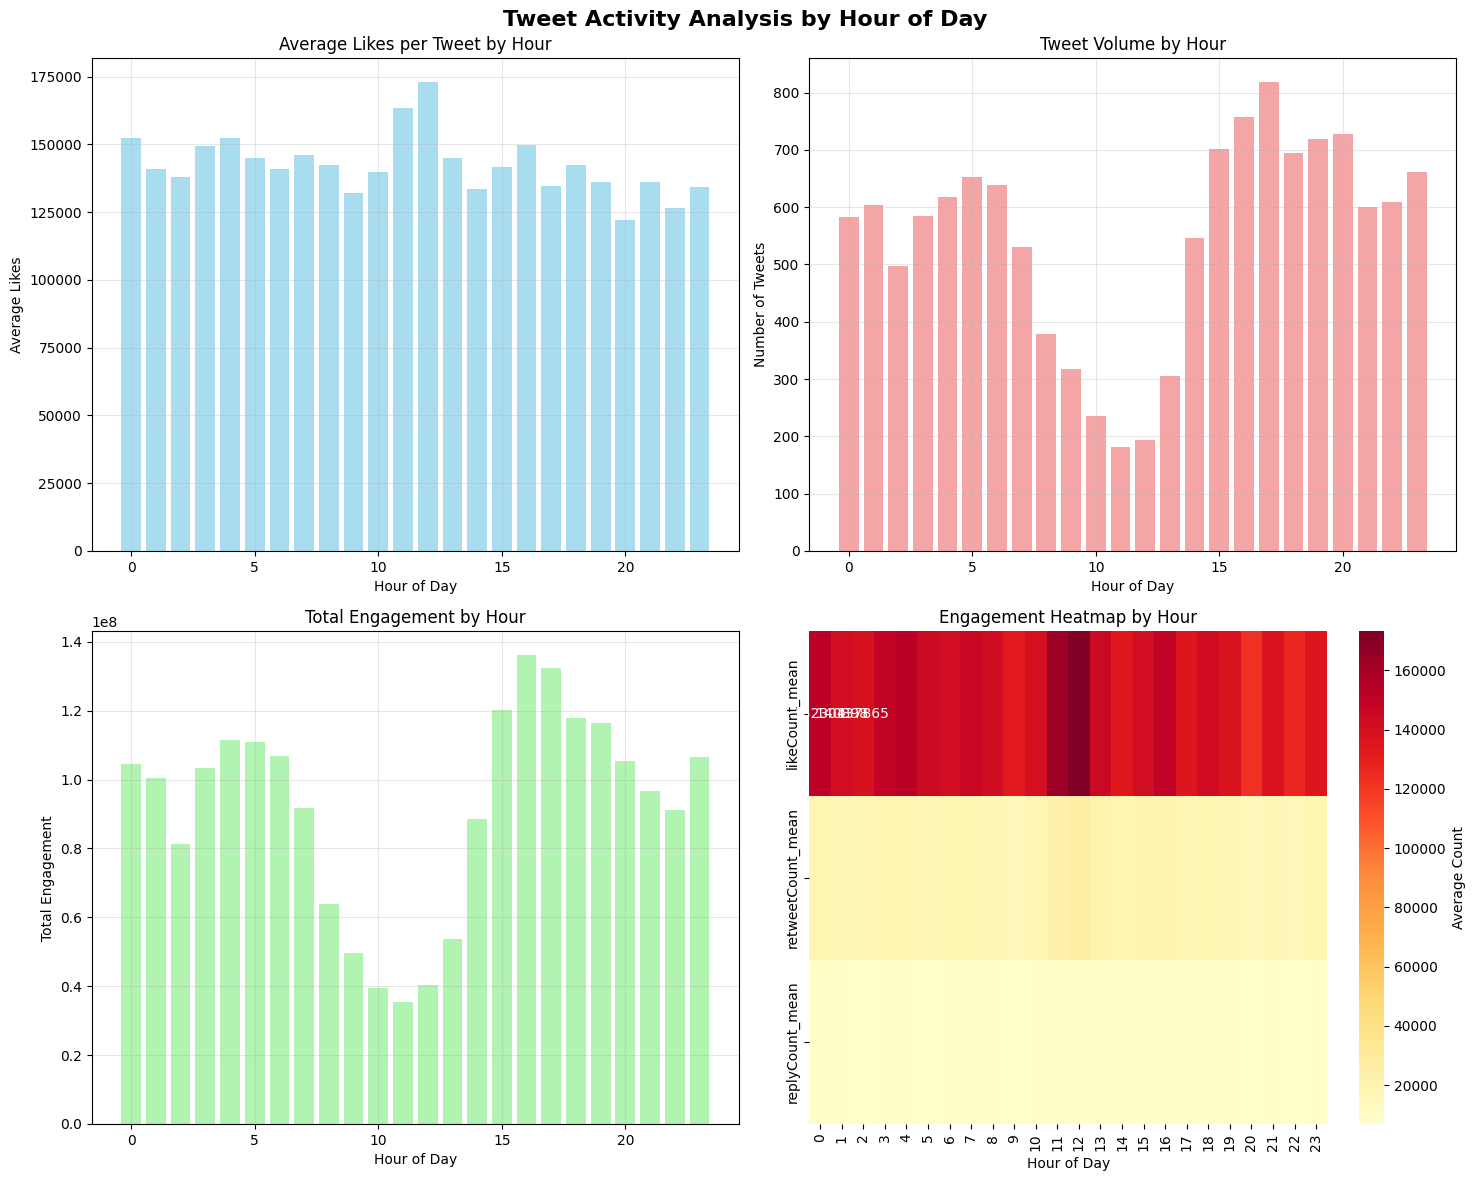

🎯 Peak engagement hour: 12:00 (avg 173,094 likes)
📈 Most active hour: 17:00 (819 tweets)


In [13]:
# Tweet Hour vs Like Count Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load tweets data
tweets = pd.read_csv(f'{clean_data_dir}/clean_musk_tweets.csv')
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
tweets['hour'] = tweets['timestamp'].dt.hour

# Calculate hourly statistics
hourly_stats = tweets.groupby('hour').agg({
    'likeCount': ['mean', 'median', 'sum', 'count'],
    'retweetCount': ['mean', 'sum'],
    'replyCount': ['mean', 'sum']
}).round(2)

# Flatten column names
hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Tweet Activity Analysis by Hour of Day', fontsize=16, fontweight='bold')

# Plot 1: Average likes per hour
axes[0, 0].bar(hourly_stats.index, hourly_stats['likeCount_mean'], 
               color='skyblue', alpha=0.7)
axes[0, 0].set_title('Average Likes per Tweet by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Likes')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Tweet volume by hour
axes[0, 1].bar(hourly_stats.index, hourly_stats['likeCount_count'], 
               color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Tweet Volume by Hour')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Total engagement by hour
total_engagement = (hourly_stats['likeCount_sum'] + 
                   hourly_stats['retweetCount_sum'] + 
                   hourly_stats['replyCount_sum'])
axes[1, 0].bar(hourly_stats.index, total_engagement, 
               color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Total Engagement by Hour')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Engagement')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Heatmap of hour vs engagement metrics
heatmap_data = hourly_stats[['likeCount_mean', 'retweetCount_mean', 'replyCount_mean']].T
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': 'Average Count'})
axes[1, 1].set_title('Engagement Heatmap by Hour')
axes[1, 1].set_xlabel('Hour of Day')

plt.tight_layout()
plt.show()

# Print insights
peak_hour = hourly_stats['likeCount_mean'].idxmax()
peak_volume_hour = hourly_stats['likeCount_count'].idxmax()
print(f"🎯 Peak engagement hour: {peak_hour}:00 (avg {hourly_stats.loc[peak_hour, 'likeCount_mean']:,.0f} likes)")
print(f"📈 Most active hour: {peak_volume_hour}:00 ({hourly_stats.loc[peak_volume_hour, 'likeCount_count']} tweets)")

# 🕐 Tweet Day vs Like Count Analysis

This section analyzes the relationship between the hour of day when Elon tweets and the engagement metrics (likes, retweets, replies). We'll explore optimal posting times and engagement patterns throughout the day.

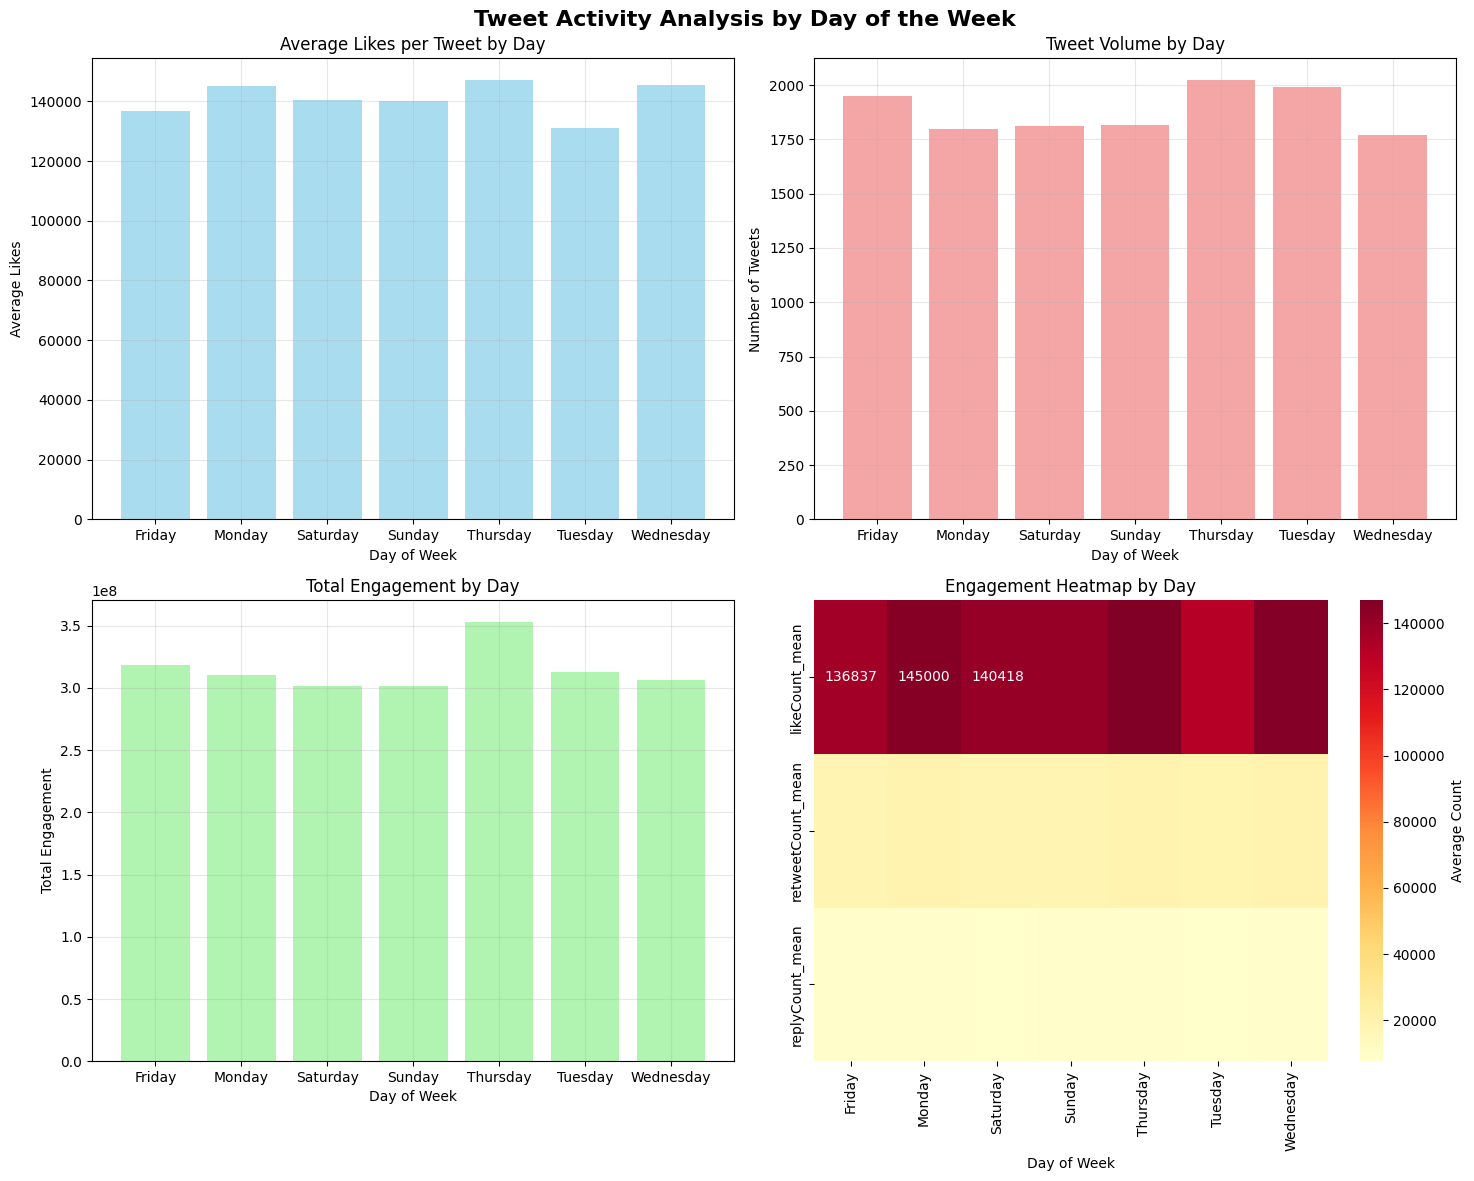

🎯 Peak engagement Day: Thursday:00 (avg 147,018 likes)
📈 Most active Day: Thursday:00 (2022 tweets)


In [ ]:
# Tweet Hour vs Like Count Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load tweets data
tweets = pd.read_csv(f'{clean_data_dir}/clean_musk_tweets.csv')
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
tweets['day'] = tweets['timestamp'].dt.day_name()

# Calculate daily statistics
daily_stats = tweets.groupby('day').agg({
    'likeCount': ['mean', 'median', 'sum', 'count'],
    'retweetCount': ['mean', 'sum'],
    'replyCount': ['mean', 'sum']
}).round(2)

# Flatten column names
daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Tweet Activity Analysis by Day of the Week', fontsize=16, fontweight='bold')

# Plot 1: Average likes per day
axes[0, 0].bar(daily_stats.index, daily_stats['likeCount_mean'], 
               color='skyblue', alpha=0.7)
axes[0, 0].set_title('Average Likes per Tweet by Day')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Average Likes')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Tweet volume by day
axes[0, 1].bar(daily_stats.index, daily_stats['likeCount_count'], 
               color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Tweet Volume by Day')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Total engagement by day
total_engagement = (daily_stats['likeCount_sum'] + 
                   daily_stats['retweetCount_sum'] + 
                   daily_stats['replyCount_sum'])
axes[1, 0].bar(daily_stats.index, total_engagement, 
               color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Total Engagement by Day')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Total Engagement')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Heatmap of hour vs engagement metrics
heatmap_data = daily_stats[['likeCount_mean', 'retweetCount_mean', 'replyCount_mean']].T
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': 'Average Count'})
axes[1, 1].set_title('Engagement Heatmap by Day')
axes[1, 1].set_xlabel('Day of Week')

plt.tight_layout()
plt.show()

# Print insights
peak_day = daily_stats['likeCount_mean'].idxmax()
peak_volume_day = daily_stats['likeCount_count'].idxmax()
print(f"🎯 Peak engagement Day: {peak_day}:00 (avg {daily_stats.loc[peak_day, 'likeCount_mean']:,.0f} likes)")
print(f"📈 Most active Day: {peak_volume_day}:00 ({daily_stats.loc[peak_volume_day, 'likeCount_count']} tweets)")

# 👥 Most Popular Retweeted Users Analysis

This section analyzes the users that Elon Musk retweets most frequently, providing insights into his Twitter network and the accounts he finds most engaging or valuable to share with his followers.

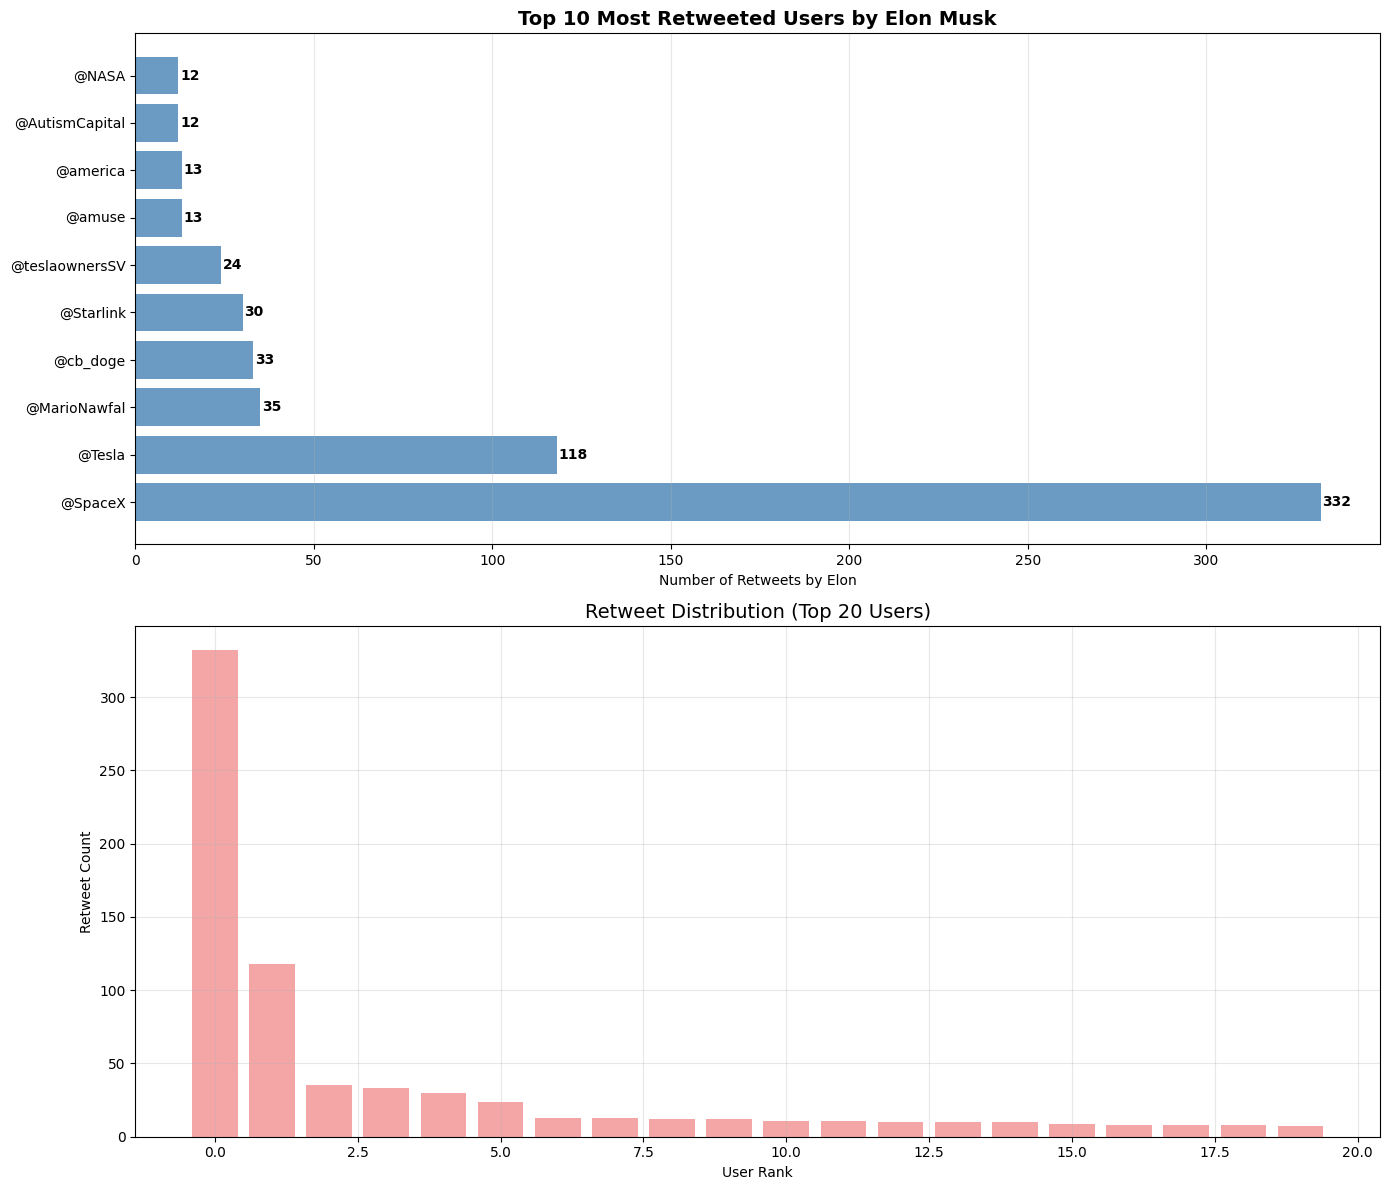

📊 RETWEET ANALYSIS SUMMARY
Total unique users retweeted: 269
Total retweets analyzed: 1,102
Average retweets per user: 4.1
Most retweeted user: @SpaceX (332 times)

🏆 TOP 10 MOST RETWEETED USERS:
 1. @SpaceX               332 retweets (30.1%)
 2. @Tesla                118 retweets (10.7%)
 3. @MarioNawfal           35 retweets (3.2%)
 4. @cb_doge               33 retweets (3.0%)
 5. @Starlink              30 retweets (2.7%)
 6. @teslaownersSV         24 retweets (2.2%)
 7. @amuse                 13 retweets (1.2%)
 8. @america               13 retweets (1.2%)
 9. @AutismCapital         12 retweets (1.1%)
10. @NASA                  12 retweets (1.1%)


In [14]:
# Most Popular Users Elon Retweeted
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load retweets data
retweets = pd.read_csv(f'{clean_data_dir}/clean_musk_retweets.csv')

# Count retweets by original author
author_counts = retweets['originalAuthor'].value_counts().head(20)

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 10 horizontal bar chart
top_10 = author_counts.head(10)
axes[0].barh(range(len(top_10)), top_10.values, color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels([f"@{author}" for author in top_10.index])
axes[0].set_xlabel('Number of Retweets by Elon')
axes[0].set_title('Top 10 Most Retweeted Users by Elon Musk', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10.values):
    axes[0].text(v + 0.5, i, str(v), va='center', fontweight='bold')

# Top 20 distribution
axes[1].bar(range(len(author_counts)), author_counts.values, color='lightcoral', alpha=0.7)
axes[1].set_xlabel('User Rank')
axes[1].set_ylabel('Retweet Count')
axes[1].set_title('Retweet Distribution (Top 20 Users)', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("📊 RETWEET ANALYSIS SUMMARY")
print("=" * 50)
print(f"Total unique users retweeted: {len(retweets['originalAuthor'].unique()):,}")
print(f"Total retweets analyzed: {len(retweets):,}")
print(f"Average retweets per user: {len(retweets) / len(retweets['originalAuthor'].unique()):.1f}")
print(f"Most retweeted user: @{author_counts.index[0]} ({author_counts.iloc[0]} times)")

print("\n🏆 TOP 10 MOST RETWEETED USERS:")
for i, (user, count) in enumerate(author_counts.head(10).items(), 1):
    percentage = (count / len(retweets)) * 100
    print(f"{i:2d}. @{user:<20} {count:3d} retweets ({percentage:.1f}%)")


# 📅 High Tweet Volume Days & World Events Analysis

This section analyzes days with the highest tweet activity from Elon Musk, including tweets, replies, and retweets. We'll explore patterns in daily activity, identify peak activity days, and examine day-of-week trends to understand his social media behavior patterns.

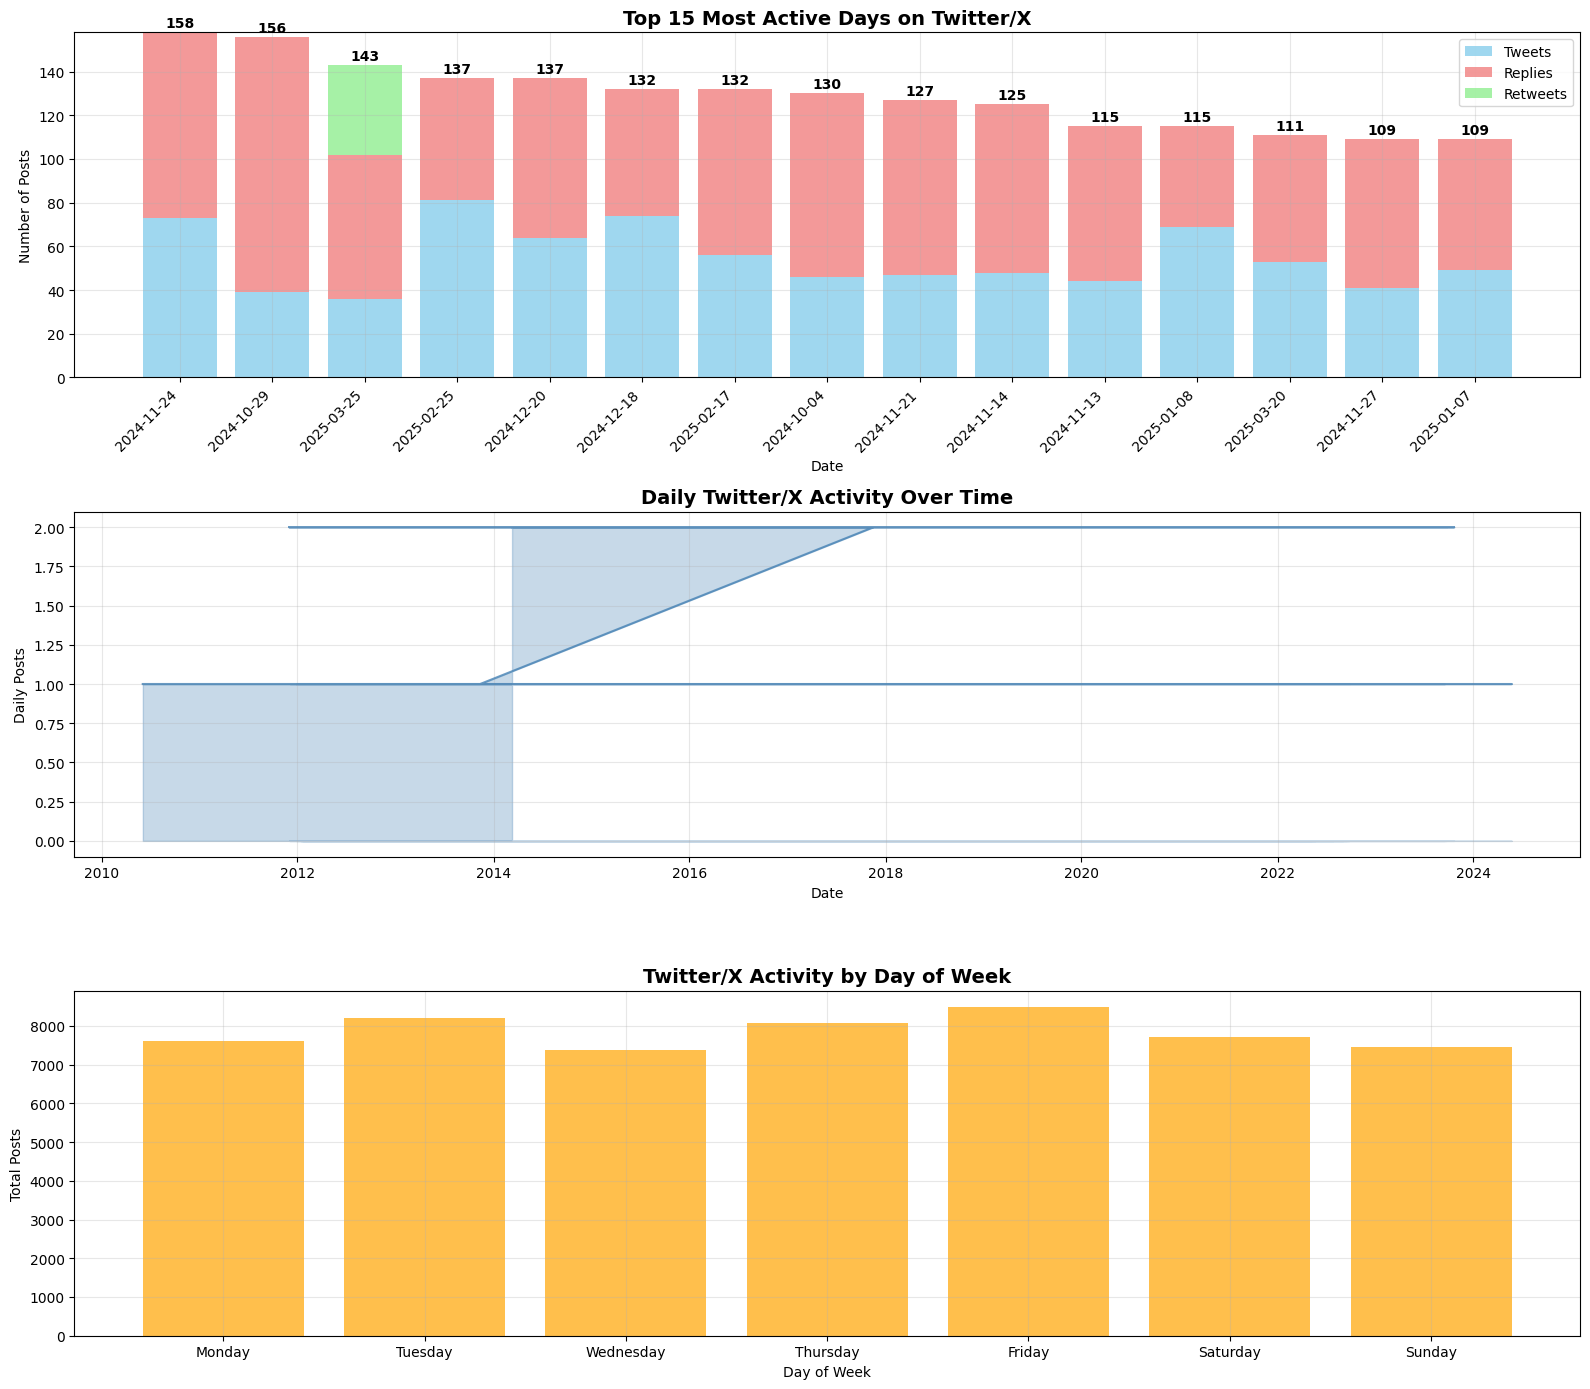

📈 HIGH ACTIVITY DAYS ANALYSIS
Highest activity day: 2024-11-24 (158 posts)
Average daily posts: 15.9
Standard deviation: 20.3

🔥 TOP 10 MOST ACTIVE DAYS:
 1. 2024-11-24 - 158 posts 
 2. 2024-10-29 - 156 posts 
 3. 2025-03-25 - 143 posts 
 4. 2025-02-25 - 137 posts 
 5. 2024-12-20 - 137 posts 
 6. 2024-12-18 - 132 posts 
 7. 2025-02-17 - 132 posts 
 8. 2024-10-04 - 130 posts 
 9. 2024-11-21 - 127 posts 
10. 2024-11-14 - 125 posts 

📊 DAY OF WEEK STATISTICS:
Monday    : 7,616 posts (13.9%)
Tuesday   : 8,210 posts (14.9%)
Wednesday : 7,385 posts (13.4%)
Thursday  : 8,069 posts (14.7%)
Friday    : 8,484 posts (15.4%)
Saturday  : 7,706 posts (14.0%)
Sunday    : 7,466 posts (13.6%)


In [15]:
# High Tweet Volume Days Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load all tweet data
tweets = pd.read_csv(f'{clean_data_dir}/clean_musk_tweets.csv')
replies = pd.read_csv(f'{clean_data_dir}/clean_musk_replies.csv')
retweets = pd.read_csv(f'{clean_data_dir}/clean_musk_retweets.csv')

# Combine all data
tweets['type'] = 'Tweet'
replies['type'] = 'Reply'
retweets['type'] = 'Retweet'

# Standardize columns
tweets_combined = tweets[['timestamp', 'type']].copy()
replies_combined = replies[['timestamp', 'type']].copy()
retweets_combined = retweets[['timestamp', 'type']].copy()

all_posts = pd.concat([tweets_combined, replies_combined, retweets_combined], ignore_index=True)
all_posts['timestamp'] = pd.to_datetime(all_posts['timestamp'])
all_posts['date'] = all_posts['timestamp'].dt.date

# Daily activity analysis
daily_activity = all_posts.groupby(['date', 'type']).size().unstack(fill_value=0)
daily_activity['total'] = daily_activity.sum(axis=1)
daily_activity = daily_activity.sort_values('total', ascending=False)

# Get top activity days
top_days = daily_activity.head(15)

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Top 15 most active days
x_pos = range(len(top_days))
bottom_tweet = top_days['Tweet'].values if 'Tweet' in top_days.columns else [0] * len(top_days)
bottom_reply = bottom_tweet + (top_days['Reply'].values if 'Reply' in top_days.columns else [0] * len(top_days))

axes[0].bar(x_pos, bottom_tweet, label='Tweets', color='skyblue', alpha=0.8)
if 'Reply' in top_days.columns:
    axes[0].bar(x_pos, top_days['Reply'].values, bottom=bottom_tweet, label='Replies', color='lightcoral', alpha=0.8)
if 'Retweet' in top_days.columns:
    axes[0].bar(x_pos, top_days['Retweet'].values, bottom=bottom_reply, label='Retweets', color='lightgreen', alpha=0.8)

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Posts')
axes[0].set_title('Top 15 Most Active Days on Twitter/X', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([str(date) for date in top_days.index], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Add total count labels
for i, total in enumerate(top_days['total']):
    axes[0].text(i, total + 1, str(total), ha='center', va='bottom', fontweight='bold')

# Plot 2: Daily activity over time (last 2 years if data available)
recent_activity = daily_activity.tail(730)  # Last 2 years
axes[1].plot(recent_activity.index, recent_activity['total'], color='steelblue', linewidth=1.5, alpha=0.8)
axes[1].fill_between(recent_activity.index, recent_activity['total'], alpha=0.3, color='steelblue')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Posts')
axes[1].set_title('Daily Twitter/X Activity Over Time', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Highlight top days
for date in top_days.head(5).index:
    if date in recent_activity.index:
        axes[1].axvline(x=date, color='red', linestyle='--', alpha=0.7)
        axes[1].text(date, recent_activity.loc[date, 'total'], f' {date}', 
                    rotation=90, va='bottom', ha='right', fontsize=8)

# Plot 3: Day of week analysis
all_posts['day_of_week'] = all_posts['timestamp'].dt.day_name()
dow_activity = all_posts.groupby('day_of_week').size()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_activity = dow_activity.reindex(dow_order)

axes[2].bar(dow_activity.index, dow_activity.values, color='orange', alpha=0.7)
axes[2].set_xlabel('Day of Week')
axes[2].set_ylabel('Total Posts')
axes[2].set_title('Twitter/X Activity by Day of Week', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Notable events analysis (you can expand this with actual events)
notable_events = {
    # Add significant dates and events here based on your data
    # Example format:
    # datetime.date(2022, 4, 25): "Twitter acquisition announcement",
    # datetime.date(2022, 10, 27): "Twitter acquisition completed",
    # Add more based on your dataset's date range
}

print("📈 HIGH ACTIVITY DAYS ANALYSIS")
print("=" * 60)
print(f"Highest activity day: {top_days.index[0]} ({top_days.iloc[0]['total']} posts)")
print(f"Average daily posts: {daily_activity['total'].mean():.1f}")
print(f"Standard deviation: {daily_activity['total'].std():.1f}")

print(f"\n🔥 TOP 10 MOST ACTIVE DAYS:")
for i, (date, row) in enumerate(top_days.head(10).iterrows(), 1):
    event_note = notable_events.get(date, "")
    print(f"{i:2d}. {date} - {row['total']:3d} posts {event_note}")

print(f"\n📊 DAY OF WEEK STATISTICS:")
for day, count in dow_activity.items():
    percentage = (count / dow_activity.sum()) * 100
    print(f"{day:<10}: {count:5,} posts ({percentage:.1f}%)")


# 📊 Tweet Performance vs Tesla Stock Correlation

This section analyzes the correlation between Elon Musk's tweet engagement metrics (likes, retweets, replies, views) and Tesla stock price movements. We'll create scatter plots and calculate correlation coefficients to understand if social media engagement has any predictive relationship with stock performance.

/var/folders/rr/ymxy9tws27z4kxt2ygvb_j040000gn/T/ipykernel_11318/3611419907.py:28: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock['price_change'] = stock['Close'].pct_change() * 100
/var/folders/rr/ymxy9tws27z4kxt2ygvb_j040000gn/T/ipykernel_11318/3611419907.py:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock['volume_change'] = stock['Volume'].pct_change() * 100


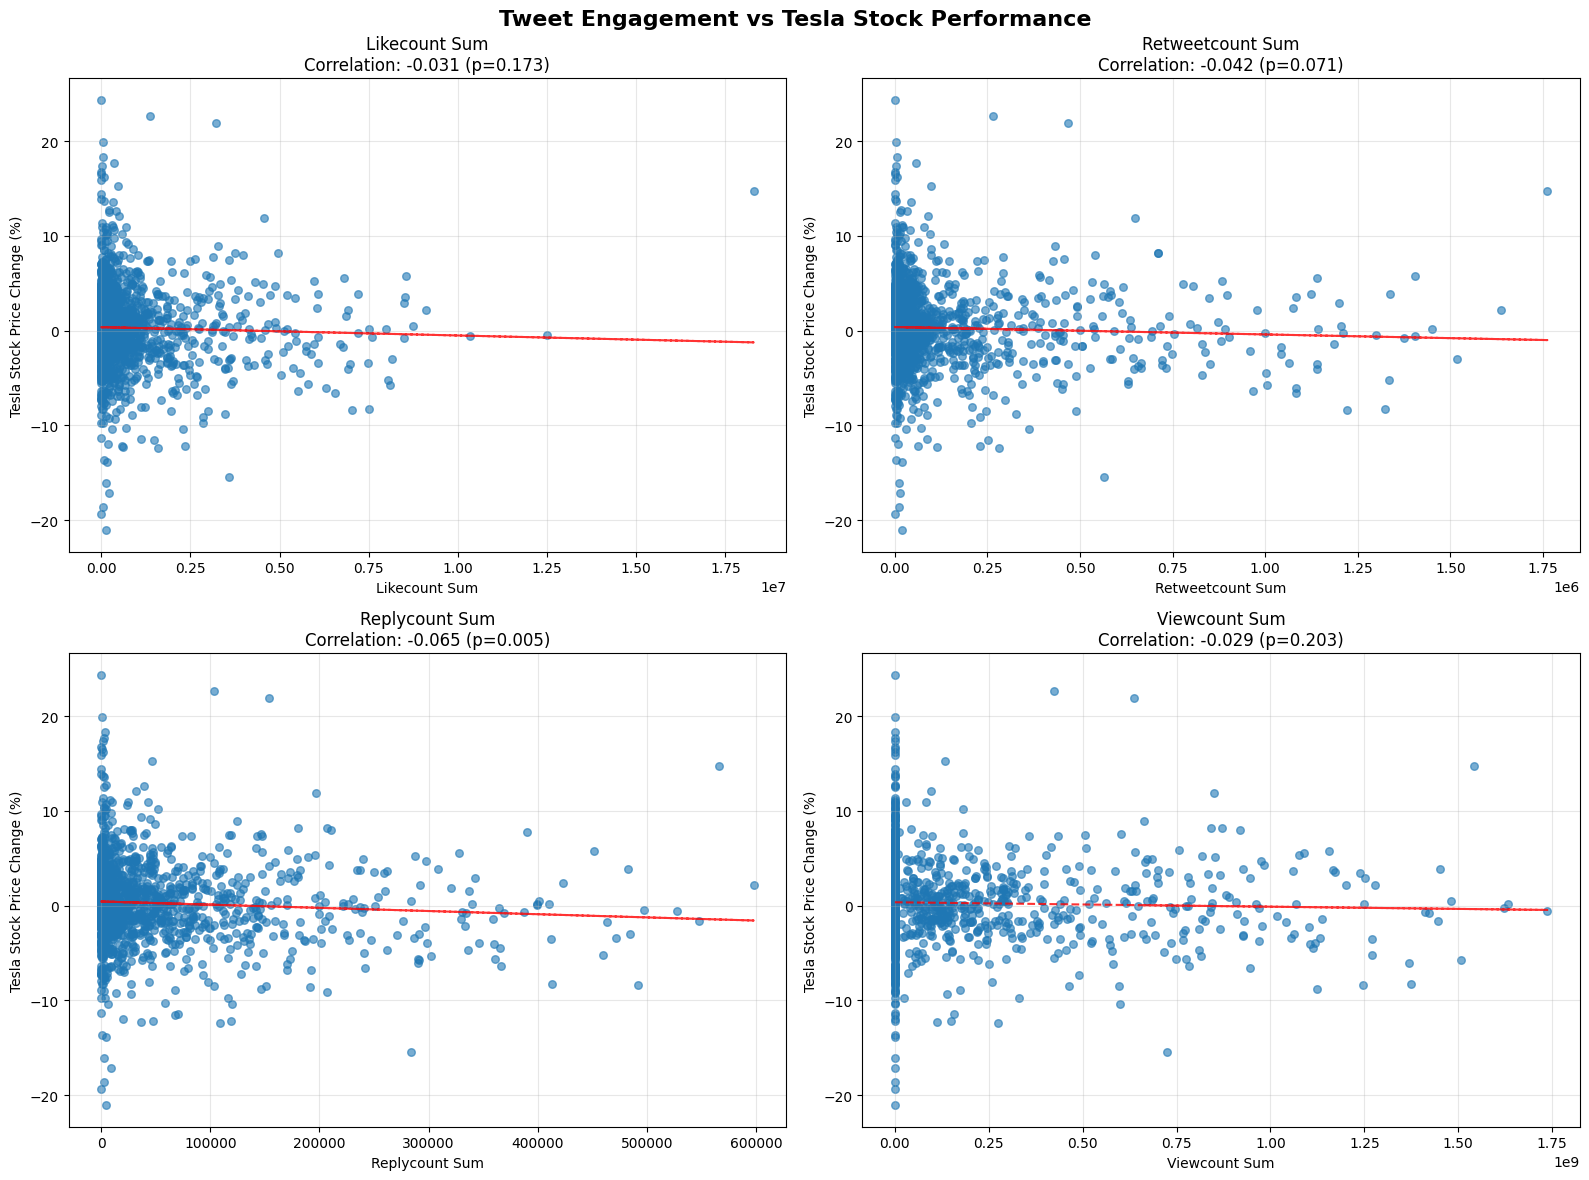

📊 TWEET ENGAGEMENT vs STOCK PERFORMANCE CORRELATIONS
Likecount Sum            :  -0.031 
Retweetcount Sum         :  -0.042 
Replycount Sum           :  -0.065 **
Viewcount Sum            :  -0.029 

Significance: *** p<0.001, ** p<0.01, * p<0.05

📈 HIGH ENGAGEMENT DAYS ANALYSIS
High engagement days (top 10%): 189
Average stock change on high engagement days: -0.32%
Average stock change on normal days: 0.39%
Difference: -0.71%


In [16]:
# Tweet Performance vs Stock Movement
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Load data
tweets = pd.read_csv(f'{clean_data_dir}/clean_musk_tweets.csv')
stock = pd.read_csv(f'{clean_data_dir}/clean_tesla_stock.csv')

# Prepare data
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
tweets['date'] = tweets['timestamp'].dt.date
stock['Date'] = pd.to_datetime(stock['Date']).dt.date

# Daily tweet metrics
daily_tweets = tweets.groupby('date').agg({
    'likeCount': ['sum', 'mean', 'max'],
    'retweetCount': ['sum', 'mean', 'max'],
    'replyCount': ['sum', 'mean', 'max'],
    'viewCount': ['sum', 'mean', 'max']
}).round(2)

daily_tweets.columns = ['_'.join(col).strip() for col in daily_tweets.columns]
daily_tweets = daily_tweets.reset_index()

# Stock daily changes
stock['price_change'] = stock['Close'].pct_change() * 100
stock['volume_change'] = stock['Volume'].pct_change() * 100

# Merge data
merged = pd.merge(daily_tweets, stock, left_on='date', right_on='Date', how='inner')

# Calculate correlations
correlations = {}
metrics = ['likeCount_sum', 'retweetCount_sum', 'replyCount_sum', 'viewCount_sum']
for metric in metrics:
    if metric in merged.columns:
        corr, p_value = pearsonr(merged[metric], merged['price_change'])
        correlations[metric] = {'correlation': corr, 'p_value': p_value}

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Tweet Engagement vs Tesla Stock Performance', fontsize=16, fontweight='bold')

# Plot correlations
for i, (metric, ax) in enumerate(zip(metrics, axes.flat)):
    if metric in merged.columns:
        ax.scatter(merged[metric], merged['price_change'], alpha=0.6, s=30)
        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_ylabel('Tesla Stock Price Change (%)')
        
        # Add trend line
        z = np.polyfit(merged[metric], merged['price_change'], 1)
        p = np.poly1d(z)
        ax.plot(merged[metric], p(merged[metric]), "r--", alpha=0.8)
        
        # Add correlation info
        if metric in correlations:
            corr = correlations[metric]['correlation']
            p_val = correlations[metric]['p_value']
            ax.set_title(f'{metric.replace("_", " ").title()}\nCorrelation: {corr:.3f} (p={p_val:.3f})')
        
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation summary
print("📊 TWEET ENGAGEMENT vs STOCK PERFORMANCE CORRELATIONS")
print("=" * 70)
for metric, stats in correlations.items():
    significance = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
    print(f"{metric.replace('_', ' ').title():<25}: {stats['correlation']:>7.3f} {significance}")
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

# Additional analysis: High engagement days vs stock performance
print("\n📈 HIGH ENGAGEMENT DAYS ANALYSIS")
print("=" * 50)

# Define high engagement threshold (top 10%)
high_engagement_threshold = merged['likeCount_sum'].quantile(0.9)
high_engagement_days = merged[merged['likeCount_sum'] >= high_engagement_threshold]
normal_days = merged[merged['likeCount_sum'] < high_engagement_threshold]

print(f"High engagement days (top 10%): {len(high_engagement_days)}")
print(f"Average stock change on high engagement days: {high_engagement_days['price_change'].mean():.2f}%")
print(f"Average stock change on normal days: {normal_days['price_change'].mean():.2f}%")
print(f"Difference: {high_engagement_days['price_change'].mean() - normal_days['price_change'].mean():.2f}%")
